<a href="https://colab.research.google.com/github/GalBuzi/colab/blob/main/inceptionV3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications import inception_v3
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
import random
import cv2
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras.models import Model
from google.colab import files
import io
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression


drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [24]:
dog_dir = 'gdrive/My Drive/dog-breed-identification/'
train_dir = dog_dir + 'train/'
csv_file = open(dog_dir + 'labels.csv')
label = pd.read_csv(csv_file)
print(label)

                                     id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]


In [25]:
label['path'] = train_dir + label.id + '.jpg'
label['id_jpg'] = label.id+'.jpg'
breed_list = label.breed.unique()

counting values of different dimensions:

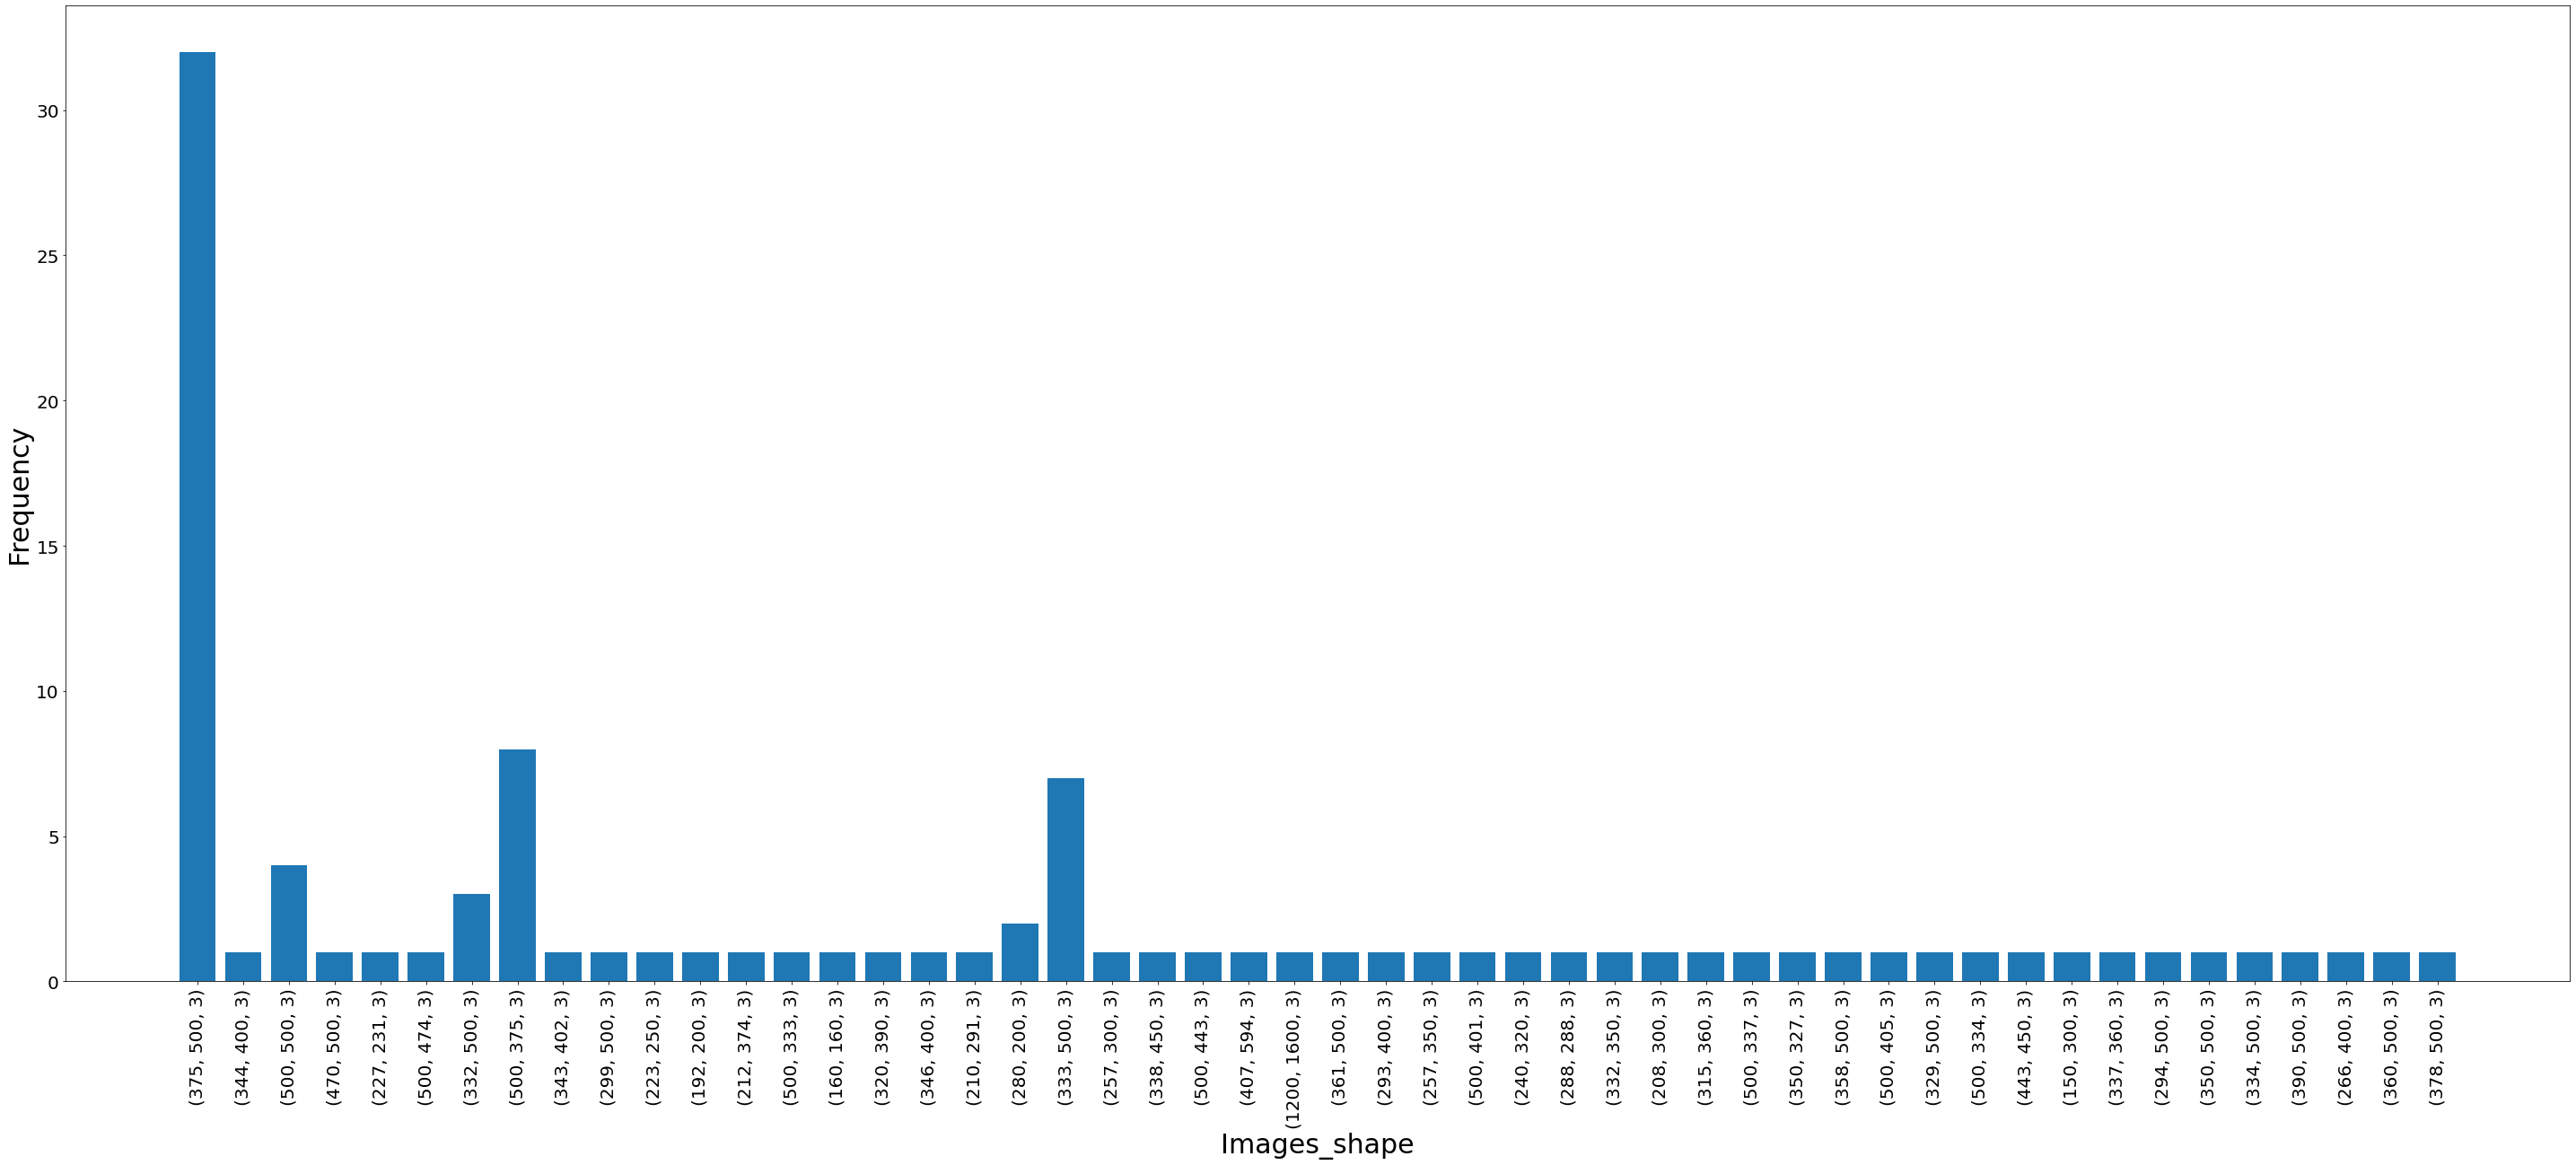

In [26]:
images_names = list(label['id_jpg'].head(100))
# find out details about the images samples
images_dim = {}
for img in images_names:
  full_path = train_dir + img
  n = cv2.imread(full_path)
  shape_string = str(n.shape)
  if not shape_string in images_dim:
    images_dim[shape_string] = 1
  else:
    images_dim[shape_string] = images_dim[shape_string]+1

plt.figure(figsize=(50,20))
plt.bar(list(images_dim.keys()),list(images_dim.values()))
plt.xlabel("Images_shape", size=30)
plt.ylabel("Frequency", size=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(dog_dir+'dogs_img_dim.jpg')
# plt.show()


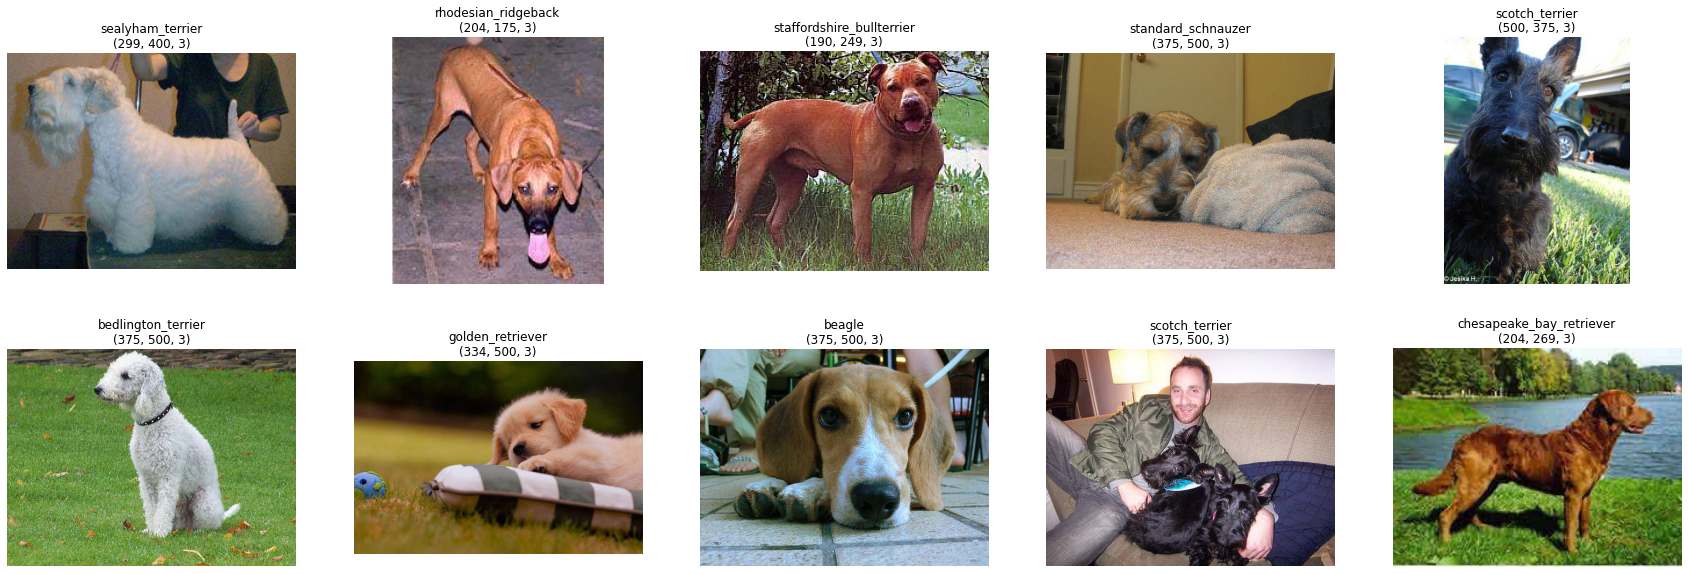

In [27]:

fig,axes = plt.subplots(2,5,figsize = (30,10))

for ax in axes.reshape(-1,):
    rnd_idx = np.random.randint(label.index[0],label.index[-1])
    file_path = label.loc[rnd_idx,'path']
    arr = plt.imread(file_path)
    ax.imshow(arr)
    ax.set_title(label.loc[rnd_idx,'breed']+'\n'+str(arr.shape))
    ax.axis('off')

plt.savefig(dog_dir+'dog_images.jpg')
# plt.show()

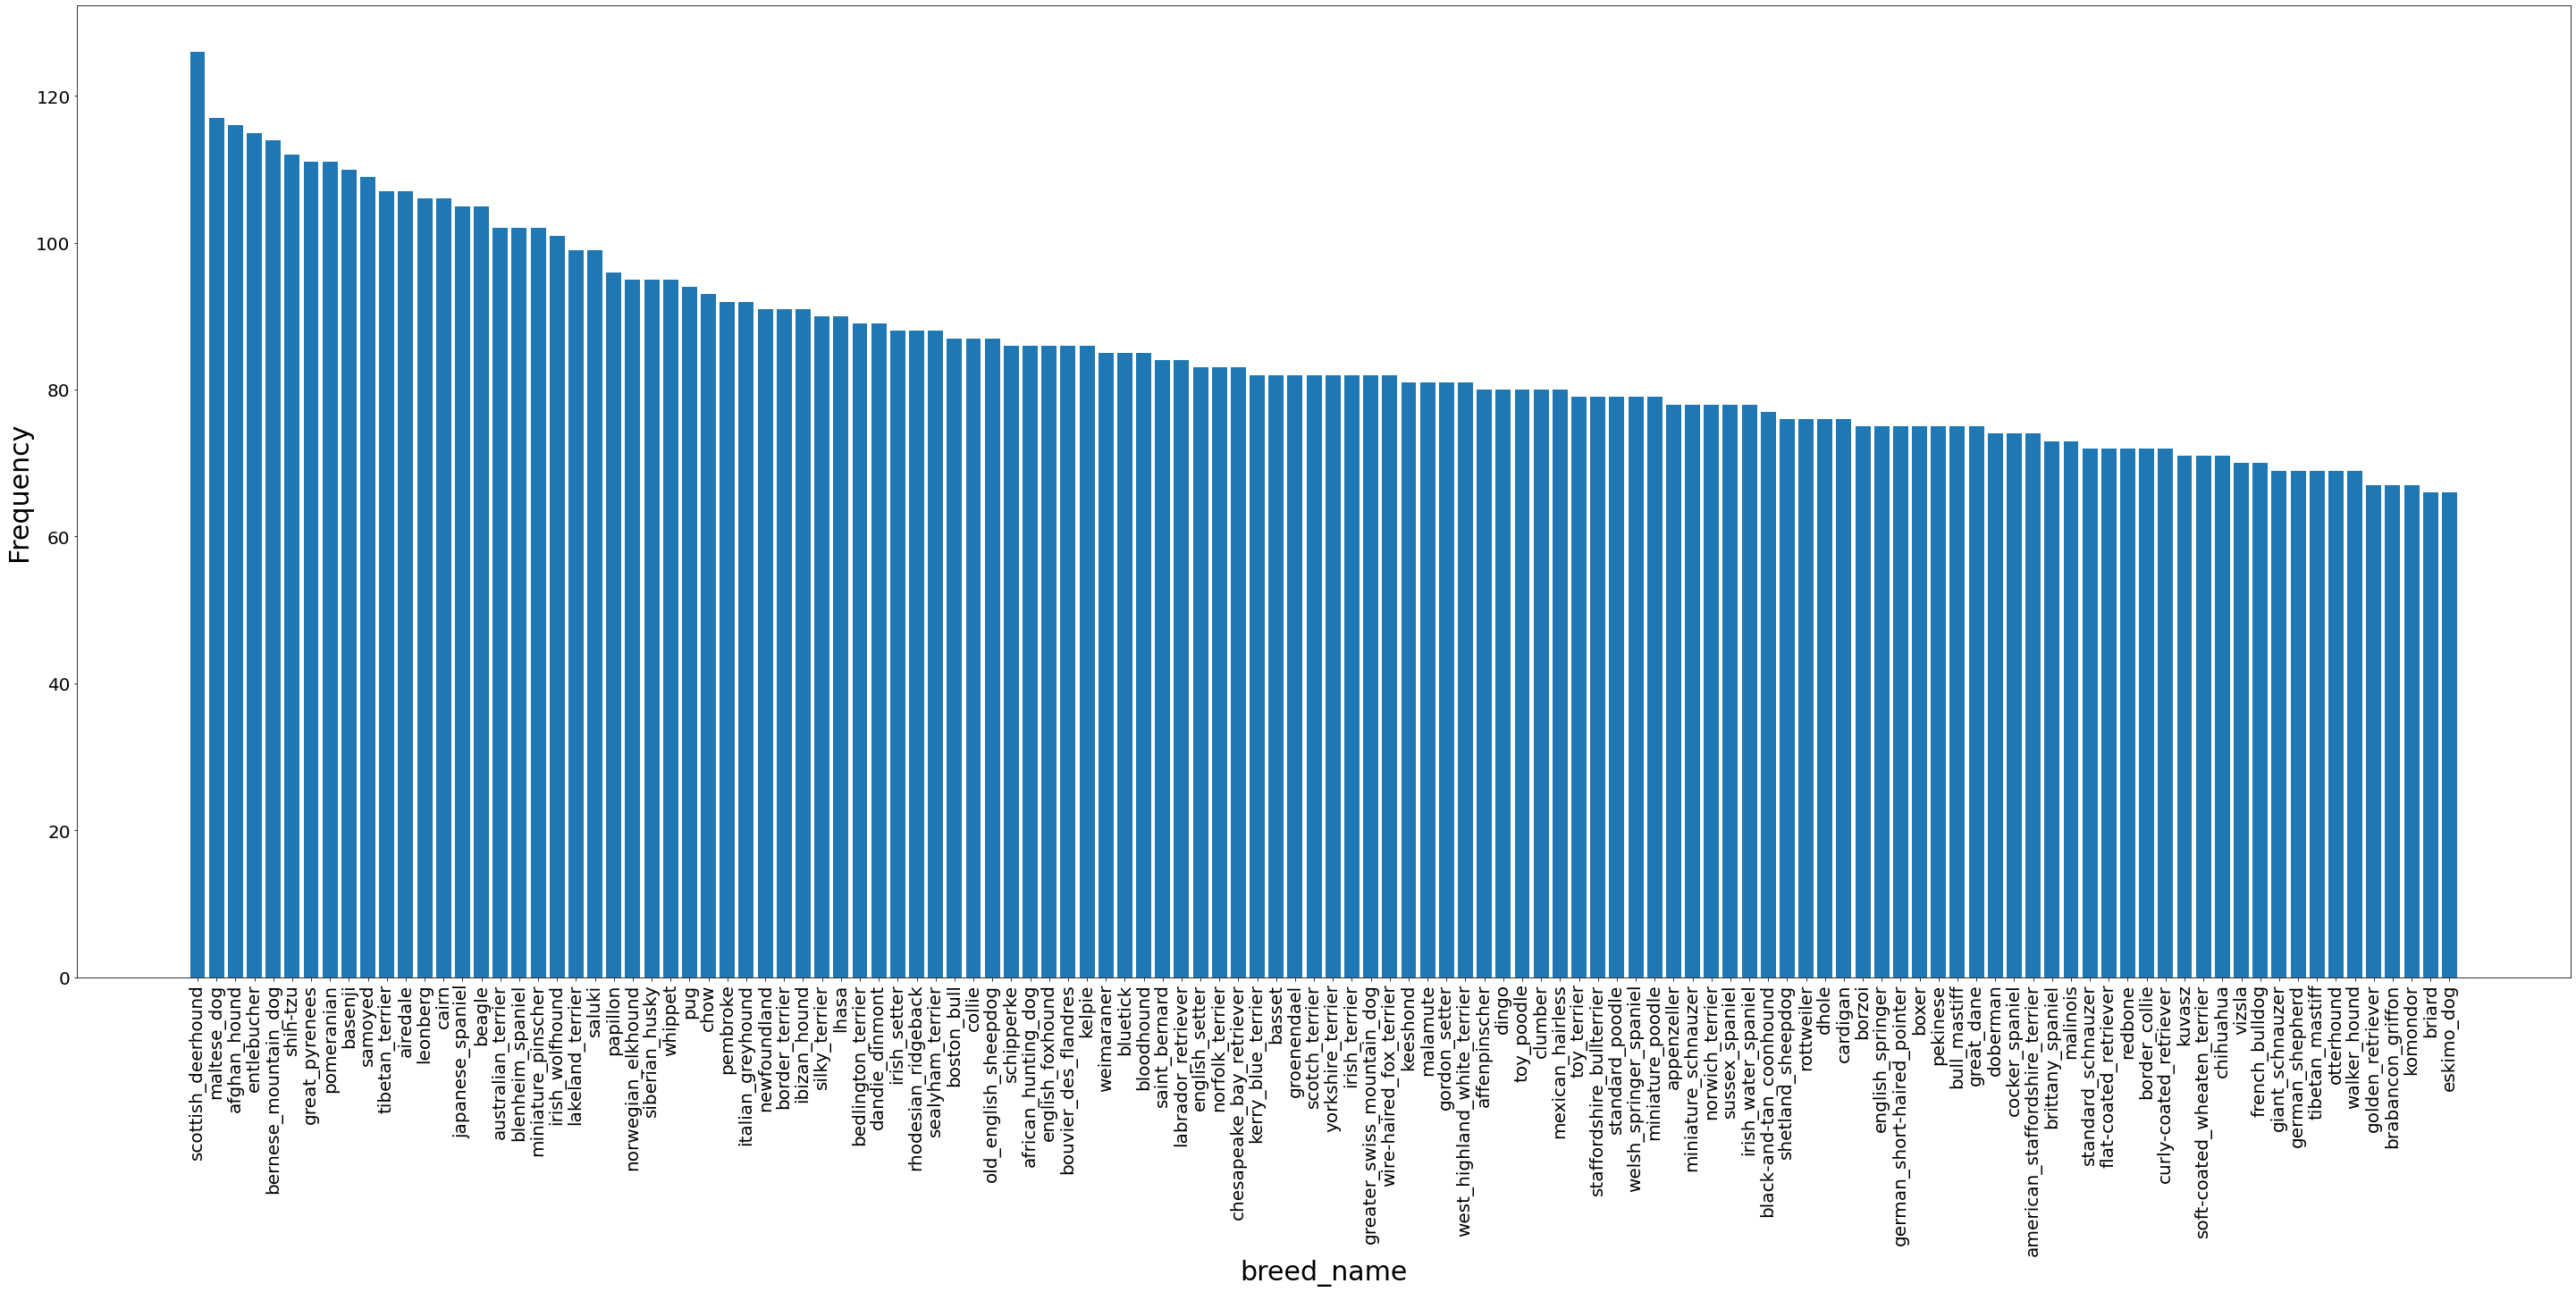

In [28]:
label_df = pd.DataFrame(label['breed'].value_counts()).reset_index() # count how many labels of each breed
label_df.columns = ['breed_name', 'count'] # change cols names
label_df.sort_values(by="count", ascending=False)

plt.figure(figsize=(50,20))
plt.bar(list(label_df['breed_name']),list(label_df['count']))
plt.xlabel("breed_name", size=30)
plt.ylabel("Frequency", size=30)
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(dog_dir+'count_breeds.jpg')
# plt.show()

a. 

*   the size of the data is: 10222 samples.

b. 

  *     the data is images of difference kinds of dogs.

  *     all images have 3 channels

  *   as we can see from the plot, all images are not of the same dimensions

  *   by first 100 images the popular dimension is (375,500)
    
  *   that means we need to pre-process our data and convert all images to same dimensions

  *   we should use augmentation to enlarge our data and decrease the overfitting

  *   because we are dealing with dogs picture, we can make augmentation like: minimal rotation, zoom in/out, horizontal flip, width/height shift range

  *   we cant use vertical flip for example because it doen't suits to the problem we are trying to solve

  *   the data is not balanced, there are over 120 images for the common breed and 60-70 images for the rare ones







In [29]:

def confusion_matrix_predict(model, validation_generator):
    preds = model.predict(validation_generator)
    predicts = np.argmax(preds, axis=1)  # return the predicted category in each sample in test set
    print(confusion_matrix(validation_generator.labels, predicts))
    print('model accuracy on test set is: {}%'.format(accuracy_score(validation_generator.labels, predicts) * 100))
    sns.heatmap(confusion_matrix(validation_generator.labels, predicts), cmap='Greens', annot=False, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Classification results on test set')
    plt.show()

def plot_history(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [30]:
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 32

In [31]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=18,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split = 0.20
)


train_generator = train_datagen.flow_from_dataframe(
    label,
    r'gdrive/My Drive/dog-breed-identification/train/',
    x_col='id_jpg',
    y_col='breed',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode = 'rgb',
    seed=42,
    shuffle=False,
    subset = 'training'
    
)


validation_generator = train_datagen.flow_from_dataframe(
    label,
    r'gdrive/My Drive/dog-breed-identification/train/',
    x_col='id_jpg',
    y_col='breed',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode = 'rgb',
    seed=42,
    shuffle=False,
    subset = 'validation',
)

classes = train_generator.class_indices


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [32]:
pre_trained_model = inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

pre_trained_model.trainable = False
for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

model = Sequential([
    pre_trained_model,
    Flatten(),
    Dense(512,activation ='relu'),
    Dropout(0.3),
    Dense(256,activation ='relu'),
    Dropout(0.3),
    Dense(120,activation = 'softmax')
])

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

train model:

In [33]:
model_checkpoint_filepath = r'gdrive/My Drive/model_saved1.hdf5'
model_checkpoint_callback = ModelCheckpoint(filepath=model_checkpoint_filepath, verbose=1, monitor='val_accuracy',
                                                mode='max', save_best_only=True)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

history = model.fit_generator(generator = train_generator,
                           epochs = 120,
                           steps_per_epoch  = train_generator.n//train_generator.batch_size,
                           validation_data  = validation_generator,
                           validation_steps = validation_generator.n//validation_generator.batch_size,
                           callbacks=[model_checkpoint_callback]
                           )


loss, accuracy = model.evaluate_generator(validation_generator, validation_generator.batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

plot_history(history) 
confusion_matrix_predict(model,validation_generator)

checking our predictions:

In [34]:
val_pred = np.argmax(model.predict(validation_generator),axis=-1)
classes = {x:y for y,x in classes.items()}

fig,axes = plt.subplots(2,5,figsize = (30,10))

for ax in axes.reshape(-1,):
    rnd_idx = np.random.randint(0,len(validation_generator.filepaths))
    arr = plt.imread(validation_generator.filepaths[rnd_idx])
    ax.imshow(arr)
    breed_true = classes[validation_generator.classes[rnd_idx]]
    breed_pred = classes[val_pred[rnd_idx]]
    
    if breed_true != classes[val_pred[rnd_idx]]:
        ax.set_title(breed_true+'\n'+ breed_pred, color = 'red',fontsize = 15)
    else:
        ax.set_title(breed_true+'\n'+ breed_pred, color = 'black',fontsize = 15)

    ax.axis('off')

loading model:

In [35]:
# model.load_weights(model_checkpoint_filepath)

# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)              

In [36]:
extract_features = Model(model.input, model.layers[-1].output)
features_of_train = extract_features.predict(train_generator)
features_of_test = extract_features.predict(validation_generator)

lrc = LogisticRegression(multi_class='multinomial', solver='lbfgs', n_jobs=8)
values_arr = list(train_generator.labels)
lrc.fit(features_of_train, values_arr)
preds = lrc.predict(features_of_test)

print(confusion_matrix(validation_generator.labels , preds))
print('model accuracy on validation set is: {}%'.format(accuracy_score(validation_generator.labels ,preds)*100))
sns.heatmap(confusion_matrix(validation_generator.labels,preds),cmap='Greens',annot=False, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('Logistic Regression accuracy after\n feature extraction from inception v3')
plt.show()